In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot

from datetime import datetime, timedelta

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import datetime
from tqdm import tqdm
from matplotlib.patches import Rectangle
import warnings

import seaborn as sns

from sklearn import svm
from sklearn.datasets import  make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples

from scipy import stats
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/k8s/datasets/nabout.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df

,cpu_usage,net_usage,disk_usage,anomaly
timestamp,,,,
2014-02-14 14:30:00,0.132,236906.0,43216100.0,False
2014-02-14 14:35:00,0.134,247200.0,863964000.0,True
2014-02-14 14:40:00,0.134,244932.0,128310000.0,True
2014-02-14 14:45:00,0.134,249894.0,0.0,False
2014-02-14 14:50:00,0.134,226273.0,125814000.0,True
...,...,...,...,...
2014-03-13 14:04:00,0.066,219813.0,7878250.0,False
2014-03-13 14:09:00,0.068,207644.0,107195000.0,True
2014-03-13 14:14:00,0.134,204319.0,44328600.0,False


In [ ]:
for column in df.columns:
    fig = px.line(df, x=df.index, y=[column], title='AWS ' + column, template = 'plotly_dark')
    fig.show()

# One Class SVM PyOD

In [ ]:
dataframe = df.copy()
dataframe.head()

,cpu_usage,net_usage,disk_usage,anomaly
timestamp,,,,
2014-02-14 14:30:00,0.132,236906.0,43216100.0,False
2014-02-14 14:35:00,0.134,247200.0,863964000.0,True
2014-02-14 14:40:00,0.134,244932.0,128310000.0,True
2014-02-14 14:45:00,0.134,249894.0,0.0,False
2014-02-14 14:50:00,0.134,226273.0,125814000.0,True


In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 483.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190251 sha256=8b08c9b578fc7d122570b8a7ce5f1ecb7dc41c9f7a3a2464982aa5049768676f
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [ ]:
from pyod.models.ocsvm import OCSVM
outliers_fraction = 0.045
random_state = np.random.RandomState(1)     # A fixed values is assigned, then no matter how many time you execute your code,values generated would be the same
#Does this mean that later on the code the outliers 5% higher than maximum value of dataset?
classifiers = {
        'One Classify SVM (SVM)':OCSVM(kernel='rbf', gamma='auto', nu=outliers_fraction, verbose=True, contamination=outliers_fraction)
}

In [ ]:
column_usage = 'cpu_usage'
X = dataframe[[column_usage]].values.reshape(-1,1)

In [ ]:
X

array([[0.132],
       [0.134],
       [0.134],
       ...,
       [0.134],
       [0.068],
       [0.068]])

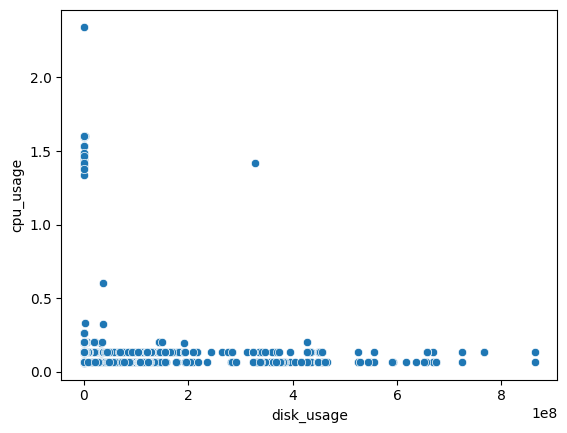

In [ ]:
sns.scatterplot(
        df,
        x='disk_usage',
        y='cpu_usage'
    )
plt.show()

In [ ]:
from scipy import stats
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)

    # copy of dataframe
    dfx = dataframe[[column_usage]]
    dfx['outlier'] = y_pred.tolist()
    #IX1 =  np.array(dfx['cpu_usage'][dfx['outlier'] == 0]).reshape(-1,1)
    #OX1 =  dfx['cpu_usage'][dfx['outlier'] == 1].values.reshape(-1,1)
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
y = dfx['outlier'].values.reshape(-1,1)

[LibSVM]OUTLIERS :  153 INLIERS :  7622 One Classify SVM (SVM)


In [ ]:
dfx

,cpu_usage,outlier
timestamp,,
2014-02-14 14:30:00,0.132,0
2014-02-14 14:35:00,0.134,0
2014-02-14 14:40:00,0.134,0
2014-02-14 14:45:00,0.134,0
2014-02-14 14:50:00,0.134,0
...,...,...
2014-03-13 14:04:00,0.066,0
2014-03-13 14:09:00,0.068,0
2014-03-13 14:14:00,0.134,0


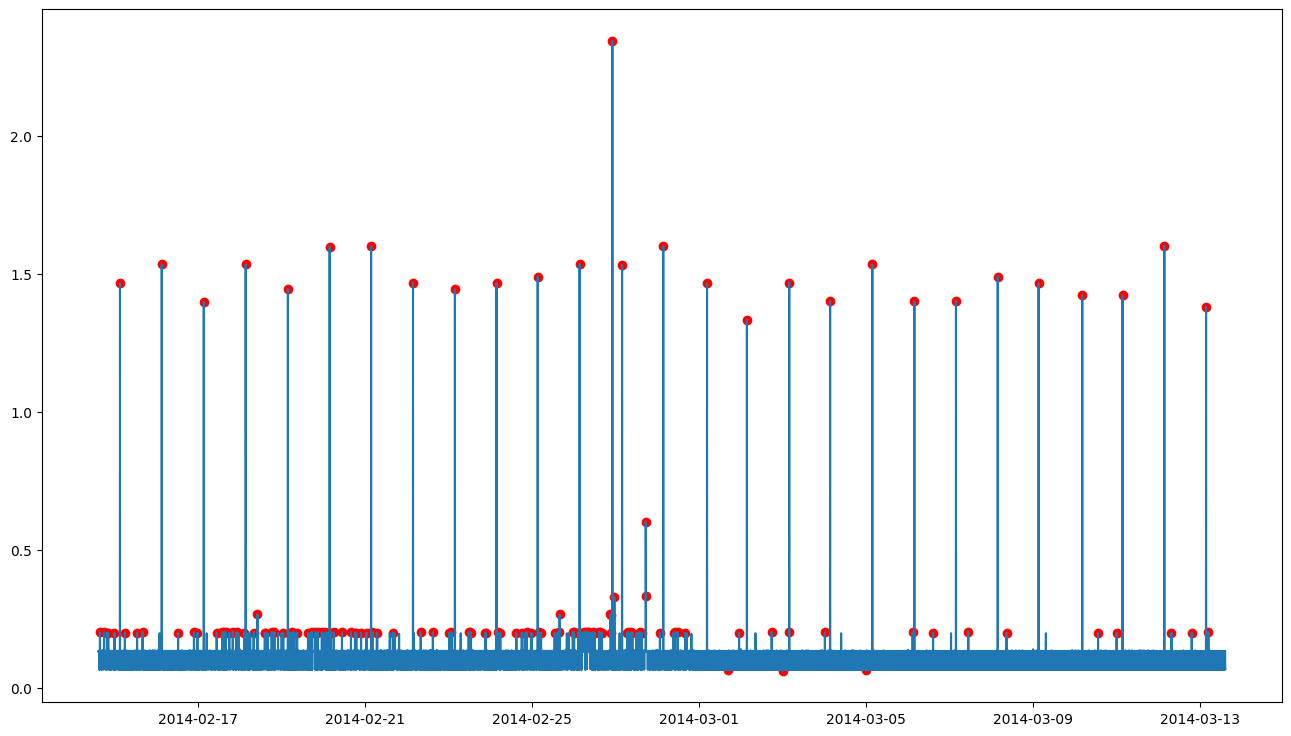

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
a = dfx.loc[dfx.outlier == 1, [column_usage]]

ax.plot(dfx.index, dfx[column_usage])
ax.scatter(a.index, a[column_usage], color='red')
plt.show()

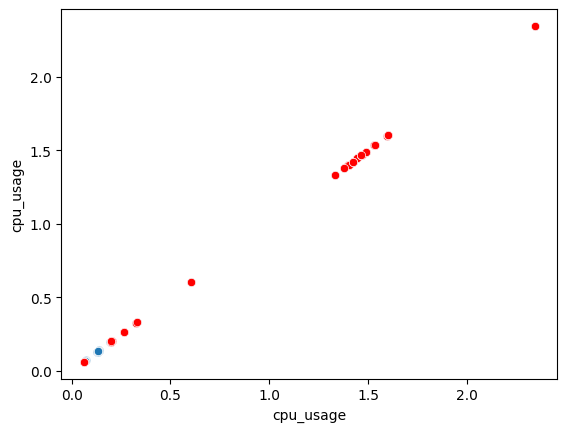

In [ ]:
sns.scatterplot(
        df,
        x=column_usage,
        y=column_usage
    )


sns.scatterplot(
        dfx.loc[dfx.outlier == 1],
        x=column_usage,
        y=column_usage,
        color='red'
    )
plt.show()

# Metrics


In [ ]:
y_pred = y_pred == 0
dfx['name'] = y_pred
y_pred

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
p_values = {}
p_stats_ = {}
percent = {}
silhoutte = {}
calinski_harabasz = {}
davies_bouldin = {}

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

cols_in = [column_usage]

In [ ]:
dfx['name'].value_counts()

True     7622
False     153
Name: name, dtype: int64

In [ ]:
#percent anomaly
dist = dfx['name'].value_counts(normalize=True)
print(dist)
percent['name'] = dist.loc[True]

True     0.980322
False    0.019678
Name: name, dtype: float64


In [ ]:
#silhouette conficient samples non-anomaly
labels = [1 if i == True else 2 for i in dfx['name']]
dfx['silhouette_zcore_'] = silhouette_samples(df[[column_usage]], labels)
silhoutte['name'] = dfx[dfx['name']]['silhouette_zcore_'].mean()

In [ ]:
#ks coeficient
normal = dfx.loc[dfx['name'] == False, [column_usage]]
anomaly = dfx.loc[dfx['name'] == True, [column_usage]]
for col_in in tqdm(cols_in):
  if len(normal)>0 and len(anomaly)>0:
    stats_, pvalue = stats.kstest(normal[col_in], anomaly[col_in])
    p_values[col_in+'_'] = pvalue
    p_stats_[col_in+'_'] = stats_

100%|██████████| 1/1 [00:00<00:00, 84.64it/s]


In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(df[[column_usage]], labels)
calinski_harabasz['name'] = round(ch_index, 3)
print("Calinski-Harabasz Index:", round(ch_index, 3))

Calinski-Harabasz Index: 2794.981


In [ ]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(df[[column_usage]], labels)
davies_bouldin['name'] = round(dbi, 3)
print("Davies-Bouldin Index:", round(dbi, 3))

Davies-Bouldin Index: 1.243


pvalue
  svm_algorithm         pvalue
0    cpu_usage_  3.477337e-236
{'cpu_usage_': 3.477337208841836e-236}


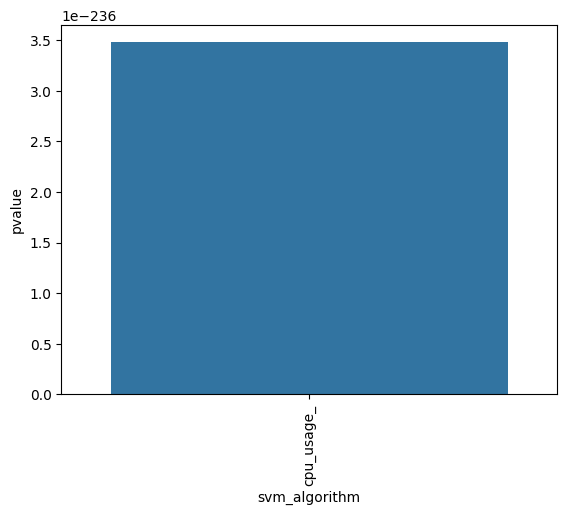

statistics
  svm_algorithm  statistics
0    cpu_usage_    0.980392
{'cpu_usage_': 0.9803921568627451}


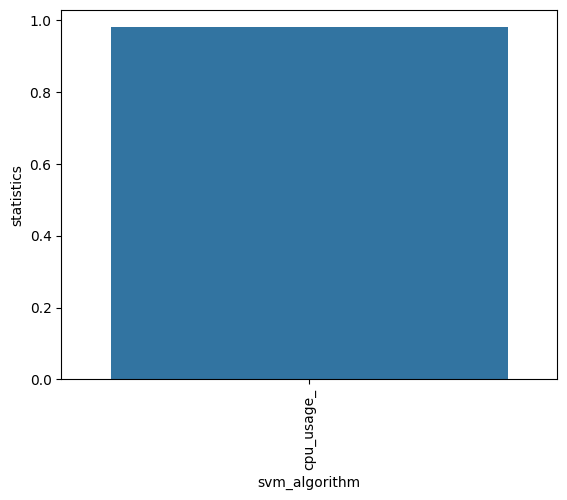

percent
  svm_algorithm   percent
0          name  0.980322
{'name': 0.9803215434083601}


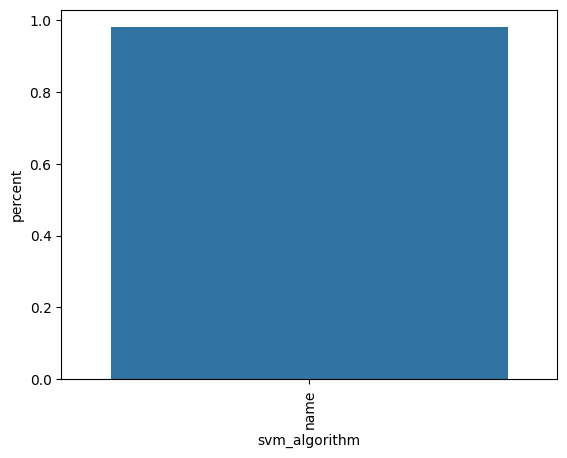

silhoutte
  svm_algorithm  silhoutte
0          name   0.898142
{'name': 0.8981418974628136}


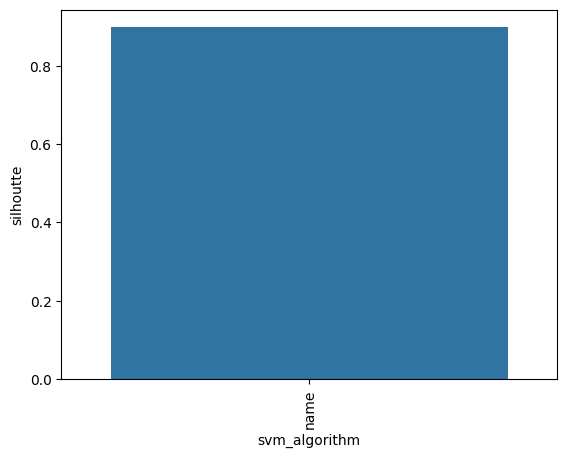

calinski_harabasz
  svm_algorithm  calinski_harabasz
0          name           2794.981
{'name': 2794.981}


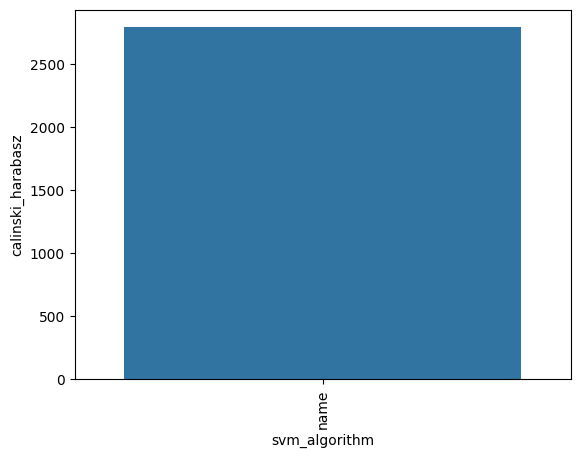

davies_bouldin
  svm_algorithm  davies_bouldin
0          name           1.243
{'name': 1.243}


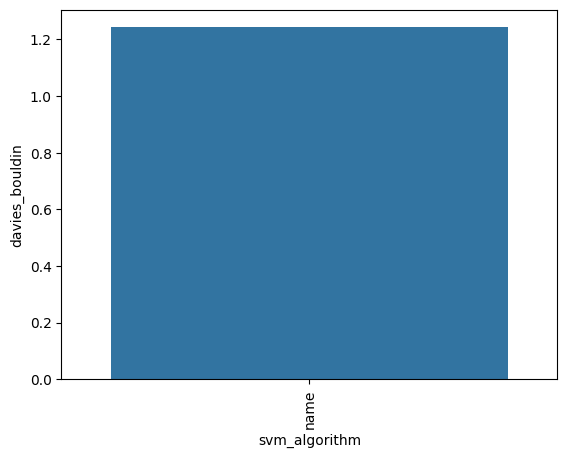

In [ ]:
for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte, 'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}.items():
    print(name)
    df_values =  pd.DataFrame([dictionary])
    df_values = df_values.T
    df_values.reset_index(inplace=True)
    df_values.columns = ['svm_algorithm', name]
    print(df_values)
    print(dictionary)

    sns.barplot(data=df_values, x='svm_algorithm', y=name)
    plt.xticks(df_values.index, df_values['svm_algorithm'].values, rotation=90)
    plt.show()

In [ ]:
for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte, 'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}.items():
    print(name + ': ' + str(np.array(list(dictionary.values())).mean()))

pvalue: 3.477337208841836e-236
statistics: 0.9803921568627451
percent: 0.9803215434083601
silhoutte: 0.8981418974628136
calinski_harabasz: 2794.981
davies_bouldin: 1.243


In [ ]:
svm_df = pd.DataFrame()
svm_df['anomaly']  = [1 if i==True else 0 for i in df.anomaly]

svm_f1 = f1_score(dfx['outlier'], svm_df['anomaly'])
print(f'One Class SVM F1 Score : {round(svm_f1 * 100,2)}%')

One Class SVM F1 Score : 15.51%
